In [1]:
from leven import levenshtein
import numpy as np
import mxnet as mx
import nltk
import math
import string
import random
random.seed(123)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import transform as skimage_tf
from mxnet.contrib.ndarray import MultiBoxPrior, MultiBoxTarget, MultiBoxDetection, box_nms
from pycontractions import Contractions
import gluonnlp

from utils.iam_dataset import IAMDataset, resize_image, crop_image
from utils.CTCDecoder.BeamSearch import ctcBeamSearch
from utils.CTCDecoder.LexiconSearch import ctcLexiconSearchWithNLTK
from utils.lexicon_search import LexiconSearch, WordSuggestor
from utils.expand_bounding_box import expand_bounding_box

from paragraph_segmentation_dcnn import make_cnn as ParagraphSegmentationNet
from line_segmentation import SSD as LineSegmentationNet
from word_segmentation import SSD as WordSegmentationNet
from handwriting_line_recognition import Network as HandwritingRecognitionNet
from handwriting_line_recognition import decode as decoder_handwriting

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
ctx = mx.gpu(0)

## Dataset creation
Obtain the original forms from the IAM dataset and plot the results.

In [ ]:
test_ds = IAMDataset("form_original", train=False)

In [ ]:
figs_to_plot = 4
images = []

for i in range(0, figs_to_plot):
    n = int(random.random()*len(test_ds))
    image, _ = test_ds[n]
    images.append(image)

In [ ]:
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 10 * len(images)/2))
for i, image in enumerate(images):
    y, x = int(i/2), int(i%2)
    axs[y, x].imshow(image, cmap='Greys_r')
    axs[y, x].axis('off')

## Paragraph segmentation
Given the image of a form in the IAM dataset, predict a bounding box of the handwriten component. The model was trained on using https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/master/paragraph_segmentation_dcnn.py and an example is presented in https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/master/paragraph_segmentation_dcnn.ipynb

In [ ]:
paragraph_segmentation_net = ParagraphSegmentationNet()
paragraph_segmentation_net.load_parameters("models/paragraph_segmentation.params")

In [ ]:
def paragraph_segmentation_transform(image, image_size):
    resized_image, _ = resize_image(image, image_size)
    
    resized_image = mx.nd.array(resized_image).expand_dims(axis=2)
    resized_image = mx.image.resize_short(resized_image, int(800/3))
    resized_image = resized_image.transpose([2, 0, 1])/255.

    resized_image = resized_image.as_in_context(ctx)
    resized_image = resized_image.expand_dims(axis=0)
    return resized_image

In [ ]:
form_size = (1120, 800)

predicted_bbs = []

fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)
    resized_image = paragraph_segmentation_transform(image, form_size)
    bb_predicted = paragraph_segmentation_net(resized_image)
    
    bb_predicted = bb_predicted[0].asnumpy()

    predicted_bbs.append(bb_predicted)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    (x, y, w, h) = bb_predicted
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[s_y, s_x].add_patch(rect)
    axs[s_y, s_x].axis('off')

#### Image processing
Crop the handwriting component out of the original IAM form.

In [ ]:
def crop_handwriting_page(image, bb, image_size):
    expanded_bb = expand_bounding_box(bb)
    image = crop_image(image, expanded_bb)

    image, _ = resize_image(image, desired_size=image_size)
    return image

In [ ]:
segmented_paragraph_size = (700, 700)
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))

paragraph_segmented_images = []

for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)

    bb = predicted_bbs[i]
    image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
    paragraph_segmented_images.append(image)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')

## Line/word segmentation
Given a form with only handwritten text, predict a bounding box for each word. The model was trained with *LINK TO WORD SEGMENTATION*

In [ ]:
def predict_bounding_boxes(net, image, min_c, overlap_thres, topk):
    '''
    Given the outputs of the dataset (image and bounding box) and the network, 
    the predicted bounding boxes are provided.
    
    Parameters
    ----------
    net: SSD
    The trained SSD network.
    
    image: np.array
    A grayscale image of the handwriting passages.
        
    Returns
    -------
    predicted_bb: [(x, y, w, h)]
    The predicted bounding boxes.
    '''
    image = mx.nd.array(image).expand_dims(axis=2)
    image = mx.image.resize_short(image, 350)
    image = image.transpose([2, 0, 1])/255.

    image = image.as_in_context(ctx)
    image = image.expand_dims(0)
    
    bb = np.zeros(shape=(13, 5))
    bb = mx.nd.array(bb)
    bb = bb.as_in_context(ctx)
    bb = bb.expand_dims(axis=0)

    default_anchors, class_predictions, box_predictions = net(image)
           
    box_target, box_mask, cls_target = net.training_targets(default_anchors, 
                                                            class_predictions, bb)

    cls_probs = mx.nd.SoftmaxActivation(mx.nd.transpose(class_predictions, (0, 2, 1)), mode='channel')

    predicted_bb = MultiBoxDetection(*[cls_probs, box_predictions, default_anchors], force_suppress=True, clip=False)
    predicted_bb = box_nms(predicted_bb, overlap_thresh=overlap_thres, valid_thresh=min_c, topk=topk)
    predicted_bb = predicted_bb.asnumpy()
    predicted_bb = predicted_bb[0, predicted_bb[0, :, 0] != -1]
    predicted_bb = predicted_bb[:, 2:]
    predicted_bb[:, 2] = predicted_bb[:, 2] - predicted_bb[:, 0]
    predicted_bb[:, 3] = predicted_bb[:, 3] - predicted_bb[:, 1]

    return predicted_bb

In [ ]:
word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("models/word_segmentation.params")

In [ ]:
min_c = 0.01
overlap_thres = 0.001
topk = 300

fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 5 * int(len(paragraph_segmented_images)/2)))
predicted_words_bbs_array = []

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)

    predicted_bb = predict_bounding_boxes(
        word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk)
    
    predicted_words_bbs_array.append(predicted_bb)
    
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')

    for j in range(predicted_bb.shape[0]):                
        (x, y, w, h) = expand_bounding_box(predicted_bb[j], expand_bb_scale_x=0.1,
                                           expand_bb_scale_y=0.02)
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)
        axs[s_y, s_x].axis('off')

#### Word to line image processing
Algorithm to group all words within a line together.

In [ ]:
def clip_value(value, max_value):
    output = value
    if output < 0:
        output = 0
    if output > max_value:
        output = max_value
    return int(output)

def get_max_coord(bbs, x_or_y):
    assert x_or_y in ["x", "y"], "x_or_y can only be x or y"
    max_value = 0.0
    for bb in bbs:
        if x_or_y == "x":
            value = bb[0] + bb[2]
        else:
            value = bb[1] + bb[3]
        if value > max_value:
            max_value = value
    return max_value

def get_min_coord(bbs, x_or_y):
    assert x_or_y in ["x", "y"], "x_or_y can only be x or y"
    min_value = 100
    for bb in bbs:
        if x_or_y == "x":
            value = bb[0]
        else:
            value = bb[1]
        if value < min_value:
            min_value = value
    return min_value

def process_line(bbs_in_a_line, min_size=5e-5):
    # Remove bbs that are very small
    bbs = []
    for bb in bbs_in_a_line:
        if bb[2] * bb[3] > min_size:
            bbs.append(bb)
    
    max_x = get_max_coord(bbs, x_or_y="x")
    min_x = get_min_coord(bbs, x_or_y="x")

    max_y = get_max_coord(bbs, x_or_y="y")
    min_y = get_min_coord(bbs, x_or_y="y")
            
    line_bb = (min_x, min_y, max_x - min_x, max_y - min_y)
    line_bb = expand_bounding_box(line_bb, expand_bb_scale_x=0.1,
                                          expand_bb_scale_y=0.1)

    return line_bb

def sort_bbs_line_by_line(bbs, line_cutoff=0.02):
    line_bbs = []
    bbs_in_a_line = []

    y_indexes = np.argsort(bbs[:, 1])
    previous_y_value = None
    for y_index in y_indexes:
        y_value = bbs[y_index, 1]
        
        if previous_y_value is not None and y_value - previous_y_value > line_cutoff: # A new line
            line_bb = process_line(bbs_in_a_line)
            #if line_bb == None:
            #    continue
            line_bbs.append(line_bb)
            bbs_in_a_line = []
        bbs_in_a_line.append(bbs[y_index, :])
        previous_y_value = y_value
    
    # process the last line
    line_bb = process_line(bbs_in_a_line)
    line_bbs.append(line_bb)
    return line_bbs

def crop_line_images(image, line_bbs):
    line_images = []
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        x1 = clip_value(x, max_value=image_w)
        x2 = clip_value(x + w, max_value=image_w)
        y1 = clip_value(y, max_value=image_h)
        y2 = clip_value(y + h, max_value=image_h)
        
        line_image = image[y1:y2, x1:x2]    
        if line_image.shape[0] > 0 and line_image.shape[1] > 0:
            line_images.append(line_image)
    line_images_array.append(line_images)
    return line_images

line_images_array = []
fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 9 * int(len(paragraph_segmented_images)/2)))

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')
    
    predicted_bbs = predicted_words_bbs_array[i]
    line_bbs = sort_bbs_line_by_line(predicted_bbs)
    line_images = crop_line_images(paragraph_segmented_image, line_bbs)
    
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)


# Handwriting recognition
Given each line of text, predict a string of the handwritten text. This network was trained with https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/language_model/handwriting_line_recognition.py

In [ ]:
handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=128,
                                                             rnn_layers=2, ctx=ctx)
handwriting_line_recognition_net.load_params("models/handwriting_line_recognition2.params")

In [16]:
line_image_size = (30, 400)
def handwriting_recognition_transform(image):
    image, _ = resize_image(image, line_image_size)
    image = mx.nd.array(image)/255.
    image = image.as_in_context(ctx)
    image = image.expand_dims(0).expand_dims(0)
    return image

In [17]:
character_probs = []
for line_images in line_images_array:
    form_character_prob = []
    for i, line_image in enumerate(line_images):
        line_image = handwriting_recognition_transform(line_image)
        line_character_prob = handwriting_line_recognition_net(line_image)
        form_character_prob.append(line_character_prob)

    character_probs.append(form_character_prob)

### Language model

In [18]:
ls = LexiconSearch()
contractions = Contractions('GoogleNews-vectors-negative300.bin.gz')
contractions.load_models()

lm_model, vocab = gluonnlp.model.get_model('awd_lstm_lm_1150', pretrained=True, ctx=ctx)

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:413: UserWarning: load_params is deprecated. Please use load_parameters.
  warnings.warn("load_params is deprecated. Please use load_parameters.")


In [19]:
#loss = mx.gluon.loss.SoftmaxCrossEntropyLoss()
alphabet_encoding = ' !"#&\'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

def get_perplexcity(line_string):
    word_tokenize = nltk.word_tokenize(line_string)
    bos_ids = [vocab[ele] for ele in word_tokenize]
    hidden = lm_model.begin_state(batch_size=1, func=mx.nd.zeros, ctx=ctx)
    input_data = mx.nd.array(bos_ids).as_in_context(ctx)
    input_data = input_data.expand_dims(1)
    output, hidden = lm_model(input_data, hidden)
    #loss_value = loss(output, input_data).sum().asnumpy()[0]#/input_data.shape[0]
    #return loss_value
    
    output_np = output.softmax(axis=2).asnumpy()
    input_np = input_data.asnumpy().astype(int)

    ppl = 0
    for i, index in enumerate(input_np):
        if i == 0:
            continue
        ppl -= math.log(float(output_np[i-1, 0, index]))
    return math.exp(ppl/(i+1))

def replace_line_with_lexicons(line_string):
    line_string = list(contractions.expand_texts([line_string]))[0]    
    word_tokenize = nltk.word_tokenize(line_string)
    correct_sentence = []
    for misspelled_words in word_tokenize:
        corrected_word = ls.minimumEditDistance_spell_corrector(misspelled_words)
        correct_sentence.append(corrected_word)
        # TODO: change contracted words back?
    return " ".join(correct_sentence)
        
def get_text_from_chracter_probs_with_language_model(probs):
    prob = probs.softmax().asnumpy()
    line_string_proposals = ctcBeamSearch(prob[0], alphabet_encoding, None, k=20)
    lexicon_line_strings = []
    for line_string in line_string_proposals:
        lexicon_line_string = replace_line_with_lexicons(line_string)
        lexicon_line_strings.append(lexicon_line_string)
        
    perplexcities = []
    for lexicon_line_string in lexicon_line_strings:
        perplexcity = get_perplexcity(lexicon_line_string)
        perplexcities.append(perplexcity)
    lowest_perplexicty_index = np.argmin(perplexcities)
    return lexicon_line_strings[lowest_perplexicty_index]

def get_arg_max(prob):
    arg_max = prob.topk(axis=2).asnumpy()
    return decoder_handwriting(arg_max)

In [20]:
#sentence = "I just hope Obama left a few bucks on the dress for her before he left the room"
sentence1 = "flying pig ugly Obama iphone."
replaced_line1 = replace_line_with_lexicons(sentence1)
print("{}={}".format(replaced_line1, get_perplexcity(replaced_line1)))

sentence2 = "I want to buy some eggs."
replaced_line2 = replace_line_with_lexicons(sentence2)
print("{}={}".format(replaced_line2, get_perplexcity(replaced_line2)))

sentence3 = "I want more voles."
replaced_line3 = replace_line_with_lexicons(sentence3)
print("{}={}".format(replaced_line3, get_perplexcity(replaced_line3)))

sentence4 = "I want more votes."
replaced_line4 = replace_line_with_lexicons(sentence4)
print("{}={}".format(replaced_line4, get_perplexcity(replaced_line4)))

flying pig ugly Obama phone .=9057.477116699423
I want to buy some eggs .=75.02547113816868
I want more voles .=39.21399968289479
I want more votes .=202.93781379229299


#### No language model

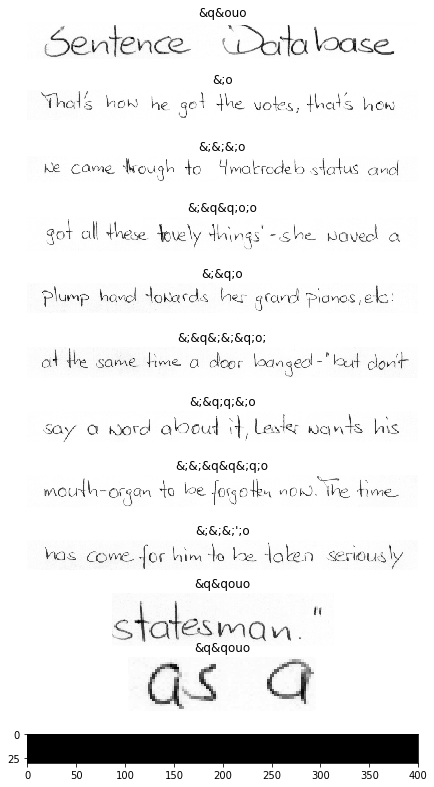

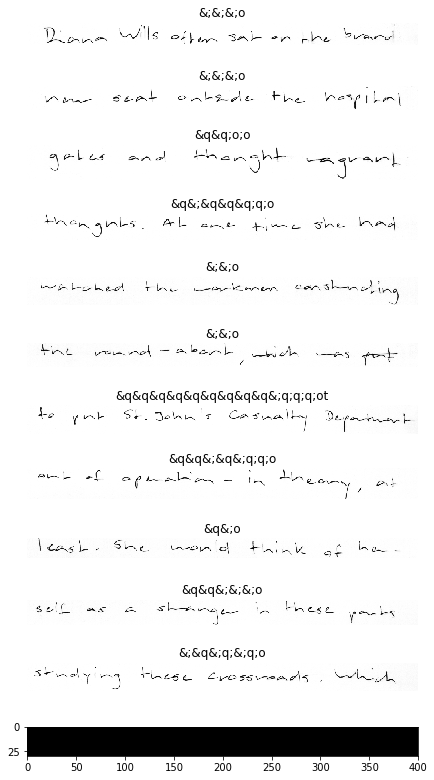

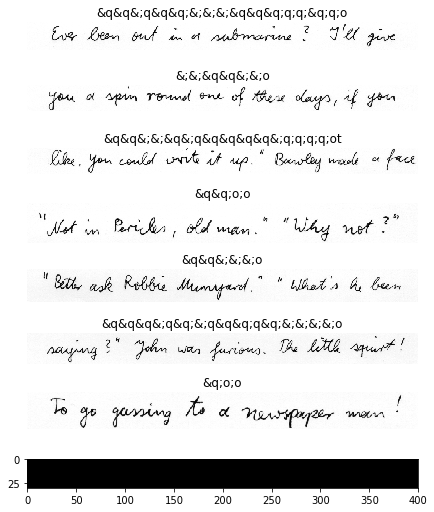

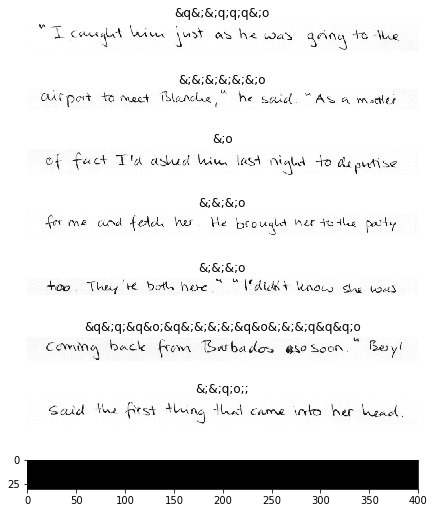

In [21]:
for i, form_character_probs in enumerate(character_probs):
    form_characters = ""
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(7, int(1 + 1.2 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line = get_arg_max(line_character_probs)[0]
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
        axs[j].set_title("{}".format(decoded_line))
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')

#### Lexicon search

In [ ]:
for i, form_character_probs in enumerate(character_probs):
    form_characters = ""
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(7, int(1 + 1.2 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line = get_arg_max(line_character_probs)[0]
        decoded_line = replace_line_with_lexicons(decoded_line)
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
        axs[j].set_title("{}".format(decoded_line))
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')

#### Lexicon and beam searching

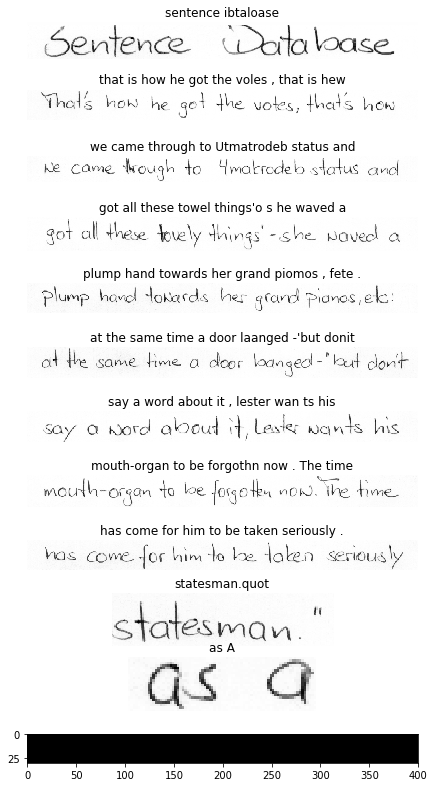

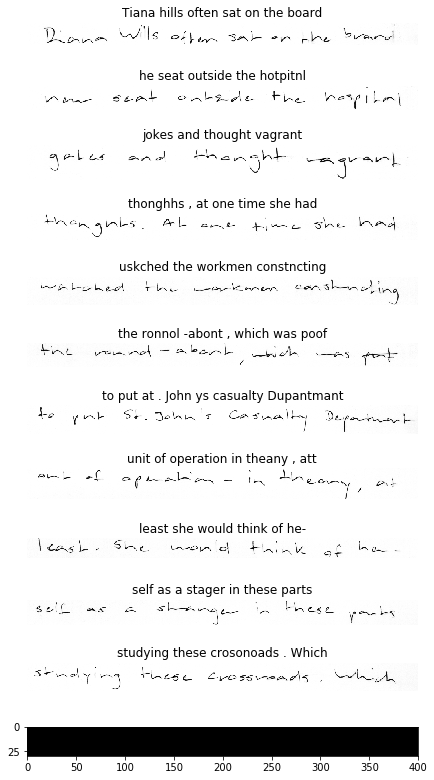

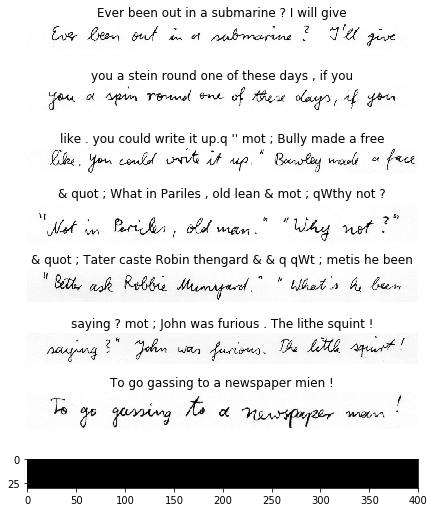

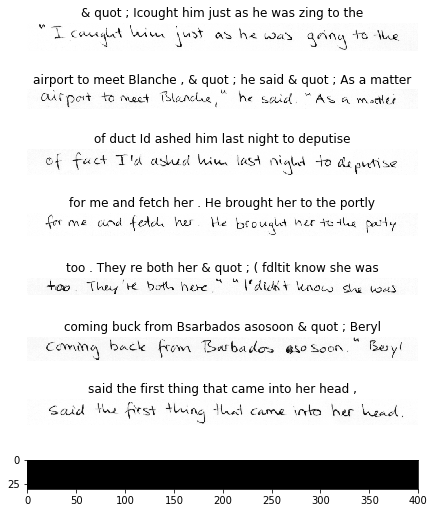

In [71]:
for i, form_character_probs in enumerate(character_probs):
    form_characters = ""
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(7, int(1 + 1.2 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line = get_text_from_chracter_probs_with_language_model(line_character_probs) 
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')
        axs[j].set_title("{}".format(decoded_line))
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')

# Quantitative Results

In [39]:
cer = []
for i in range(len(test_ds)):
    image, text = test_ds[i]
    resized_image = paragraph_segmentation_transform(image, image_size=(1120, 800))
    paragraph_bb = paragraph_segmentation_net(resized_image)
    paragraph_segmented_image = crop_handwriting_page(image, paragraph_bb[0].asnumpy(), image_size=(700, 700))
    word_bb = predict_bounding_boxes(word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk)
    line_bbs = sort_bbs_line_by_line(word_bb)
    line_images = crop_line_images(paragraph_segmented_image, line_bbs)
    all_decoded_text = ""
    for line_image in line_images:
        line_image = handwriting_recognition_transform(line_image)
        character_probabilities = handwriting_line_recognition_net(line_image)
        character_predictions = character_probabilities.softmax().topk(axis=2).asnumpy()
        decoded_text = decoder_handwriting(character_predictions)
        all_decoded_text += decoded_text[0]
    dist = levenshtein(all_decoded_text, text[0])
    length = len(text[0])
    cer.append(dist/length)
    #print("{}\n\n\n{}\n\n{}/{} = {}".format(all_decoded_text, text[0], dist, length, dist/length))
print("Mean CER = {}%".format(np.mean(cer * 100)))

Mean CER = 0.23632527265172554
